## Feature importance

We implement three methods for feature importance:
- permutation importance
- weights from the fitted classifier
- Multipass and SHAP
- DropCol (custom-made)

It either uses weights from the fitted classifier or calculates permutation importance. The latter is more computationally expensive but more reliable for all kinds of classifiers.

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import json
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

import skexplain
from skexplain.common.importance_utils import to_skexplain_importance

from src.acnets.pipeline import MultiScaleClassifier, Parcellation

In [2]:
N_RUNS = 100      # 10 independent train/test runs
TEST_SIZE = .25  # proportion of test subjects out of 32 subjects

PARAM_FILE = 'models/multiscale_classifier-XGBClassifier-hpo.json'

# load parameters and init model
with open(PARAM_FILE, 'r') as f:
    model_params = json.load(f)
    del model_params['classifier']
    classifier = XGBClassifier(base_score=.5, objective='binary:logistic')
    model = MultiScaleClassifier(classifier=classifier).set_params(**model_params)


In [3]:
# Xy
subjects = Parcellation(atlas_name='dosenbach2010').fit_transform(None).coords['subject'].values
X = subjects.reshape(-1,1)                                  # subjects ids, shape: (n_subjects, 1)

y_encoder = LabelEncoder()
y = y_encoder.fit_transform([s[:4] for s in subjects])      # labels (AVGP=1 or NVGP=1), shape: (n_subjects,)
y_mapping = dict(zip(y_encoder.classes_, y_encoder.transform(y_encoder.classes_)))

# DEBUG (report label mapping)
print('[DEBUG] label mapping:', y_mapping)

# DEBUG (expected to overfit, i.e., accuracy is 1)
overfit_score = model.fit(X, y).score(X, y)
print(f'[DEBUG] overfit accuracy: {overfit_score:.3f}')

[DEBUG] label mapping: {'AVGP': 0, 'NVGP': 1}
[DEBUG] overfit accuracy: 1.000


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.7s finished


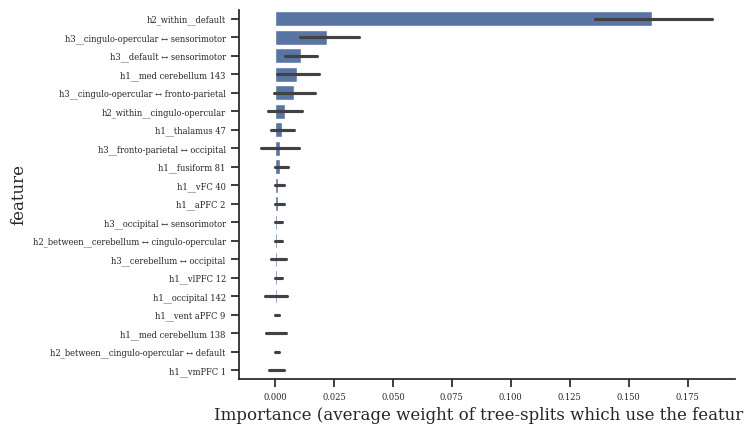

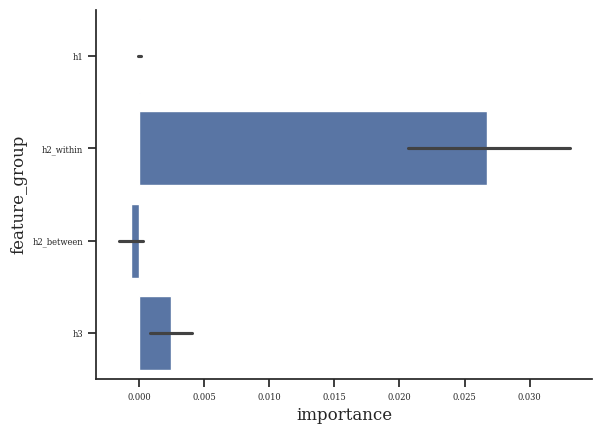

In [4]:
# Permutation Feature Importance

def get_importance(estimator, X_train, y_train, X_test, y_test, scoring='accuracy', use_coef=False):
    """Perform permutation importance analysis on a given estimator."""

    estimator.fit(X_train, y_train)
    feature_names = estimator.get_feature_extractor().get_feature_names_out()
    selected_feature_names = estimator[2:-1].get_feature_names_out(feature_names)

    if use_coef and 'xgb' in estimator.named_steps['clf'].__class__.__name__.lower():
        # for xgb classifier we use its booster's get_score() method
        booster = estimator.named_steps['clf'].get_booster()
        booster.feature_names = selected_feature_names.tolist()
        importance = booster.get_score(importance_type='weight', fmap='')
    elif use_coef and 'feature_importances_' in dir(estimator.named_steps['clf']):
        # for some other classifiers we use their feature_importances_ attribute
        importance = estimator.named_steps['clf'].feature_importances_
        importance = dict(zip(feature_names, importance))
    else:
        # generic permutation importance
        X_test_features = estimator.get_feature_extractor().transform(X_test)
        feature_names = estimator.get_feature_extractor().get_feature_names_out()
        importance = permutation_importance(estimator.get_classification_head(),
                                            X_test_features,
                                            y_test,
                                            n_jobs=-1,
                                            scoring=scoring)['importances_mean']
        importance = dict(zip(feature_names, importance))

    importance_df = pd.DataFrame([(k, v)
                                  for k, v in importance.items()],
                                 columns=['feature', 'importance'])
    return importance_df


# run permutation importance in parallel
importances = Parallel(n_jobs=-1, verbose=2)(
    delayed(get_importance)(
        estimator = model,
        X_train = X[train],
        y_train = y[train],
        X_test = X[test],
        y_test = y[test],
        use_coef=False)
    for train, test in StratifiedShuffleSplit(n_splits=N_RUNS, test_size=TEST_SIZE).split(X, y)
)

# convert importance scores to dataframe and sort
importances = pd.concat(importances, axis=0).reset_index(drop=True)
importances['feature_group'] = importances['feature'].apply(lambda x: x.split('__')[0])

# sort features by mean importance and select top-20 
order = (importances.groupby('feature')[['importance']]
                    .mean()
                    .sort_values('importance', ascending=False)[:20].index)

sns.barplot(data=importances,
            order=order,  
            x='importance',
            y='feature',
            errorbar=('ci', 95),
            orient='h')

plt.xlabel('Importance (average weight of tree-splits which use the feature)')
plt.show()

# plot feature-group importance
sns.barplot(data=importances,
            x='importance',
            y='feature_group',
            errorbar=('ci', 95),
            orient='h')
plt.show()

### Multipass & SHAP Feature Importances

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


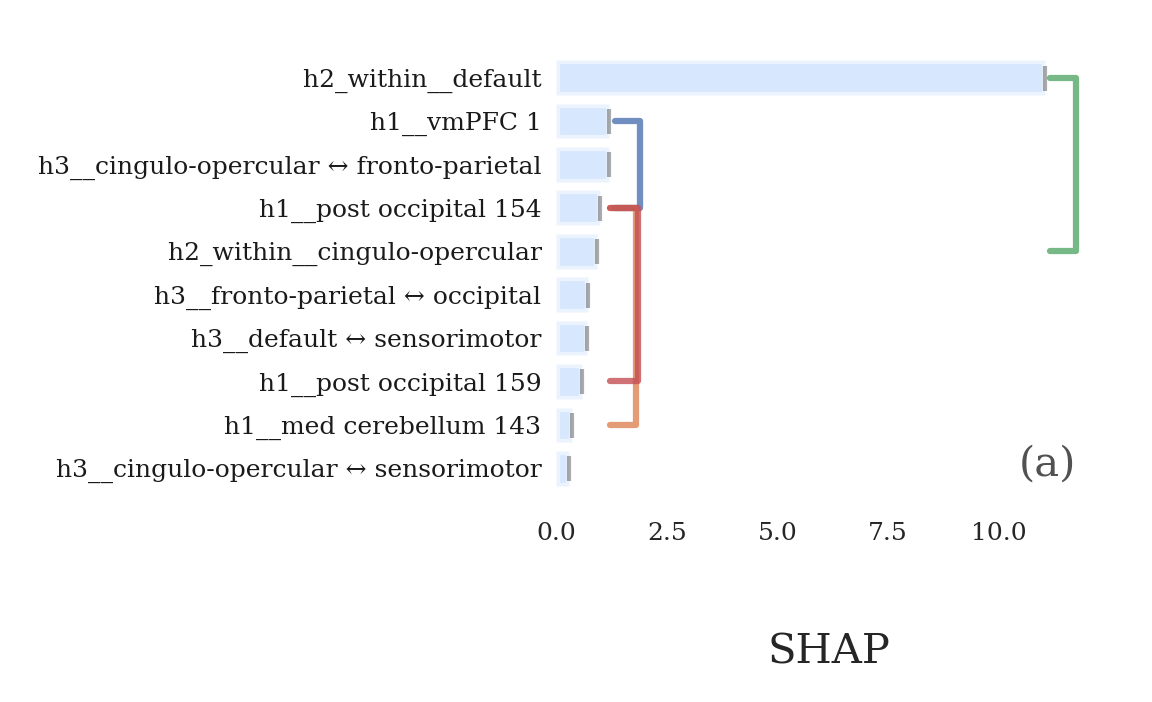

Perm. Imp.: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


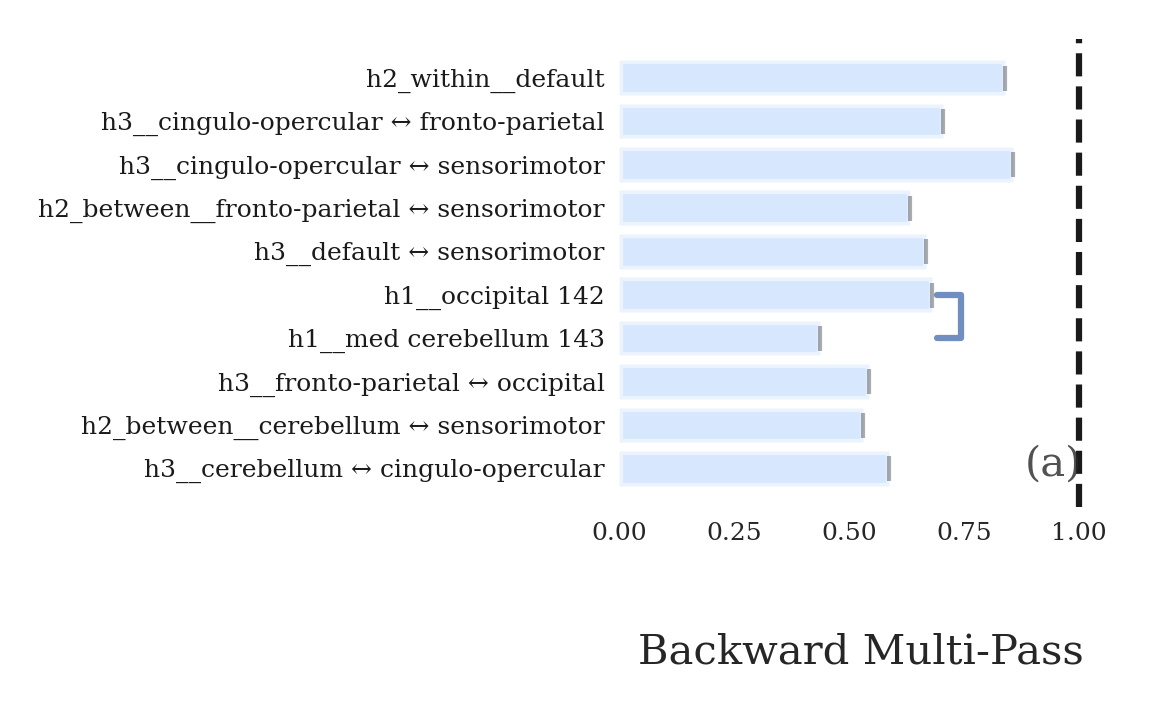

In [7]:
# Scikit-explain


# Loads three ML models (random forest, gradient-boosted tree, and logistic regression)
# trained on a subset of the road surface temperature data from Handler et al. (2020).

estimator = model.fit(X, y)
X_features = estimator.get_feature_extractor().transform(X)
feature_names = estimator.get_feature_extractor().get_feature_names_out()

explainer = skexplain.ExplainToolkit(('xgb', estimator.get_classification_head()),
                                     estimator_output='raw',
                                     X=X_features,y=y, feature_names=feature_names)


# SHAP
shap_results = explainer.local_attributions(method='shap')['shap_values__xgb'].values
shap_data = to_skexplain_importance(shap_results, estimator_name='xgb', 
                                      feature_names=feature_names, method='shap_sum')
explainer.plot_importance(data=shap_data,
                          panels = [('shap_sum', 'xgb')],
                          plot_correlated_features=True,
                          rho_threshold=0.7,
                          figsize=(4, 2.5),
                          method='shap')

plt.show()

# multipass
perm_results = explainer.permutation_importance(n_vars=10, direction='backward', evaluation_fn='auc')
explainer.plot_importance(data=perm_results,
                          panels=[('backward_multipass', 'xgb')],
                          plot_correlated_features=True,
                          rho_threshold=0.7,
                          figsize=(4, 2.5),
                          )

plt.show()

### Drop-Column Feature Importance

In [6]:
%%script echo skipping drop-column feature importance...
# DropCol feature importance

def get_dropcol_importance(estimator, X_train, y_train, X_test, y_test, scoring='accuracy'):

    estimator.fit(X, y)  # just fit if not already fitted
    feature_names = estimator.get_feature_extractor().get_feature_names_out()
    X_train_features = estimator.get_feature_extractor().transform(X_train)
    X_test_features = estimator.get_feature_extractor().transform(X_test)
    clf = estimator.get_classification_head()

    importances = []
    for i, feat_name in enumerate(feature_names):
        X_train_drop = np.delete(X_train_features, i, axis=1)
        X_test_drop = np.delete(X_test_features, i, axis=1)
        clf.fit(X_train_drop, y_train)
        importance = permutation_importance(clf,
                                            X_test_drop,
                                            y_test,
                                            n_jobs=-1,
                                            scoring=scoring)['importances_mean']
        new_feature_names = list(feature_names).copy()
        new_feature_names.remove(feat_name)
        importance = list(zip(new_feature_names, importance))
        importances.extend(importance)

    return importances

# run permutation importance in parallel
importances = Parallel(n_jobs=-1, verbose=2)(
    delayed(get_dropcol_importance)(
        estimator = tuned_model,
        X_train = X[train],
        y_train = y[train],
        X_test = X[test],
        y_test = y[test])
    for train, test in StratifiedShuffleSplit(n_splits=N_RUNS, test_size=TEST_SIZE).split(X, y)
)
pd.DataFrame([item for sublist in importances for item in sublist], columns=['feature', 'importance']).groupby('feature').mean().sort_values('importance', ascending=False)



skipping drop-column feature importance...
